I set all of the `enc_shape = es` for every instance of the autoencoder. So just set `es=2, es=4`... to get all of the autoencoders.

In [31]:
es = 2

https://github.com/techshot25/Autoencoders/blob/master/simple-autoencoder.ipynb
This simple code shows you how to make an autoencoder using Pytorch. The idea is to bring down the number of dimensions (or reduce the feature space) using neural networks.

The idea is simple, let the neural network learn how to make the encoder and the decoder using the feature space as both the input and the output of the network.

### Import relevant packages

In [32]:
import torch
from torch import nn, optim
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [33]:
import cython 

import skfda
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from skfda.exploratory.depth import ModifiedBandDepth, IntegratedDepth
from skfda.exploratory.visualization import Boxplot

from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot,
)
from skfda.ml.clustering import FuzzyCMeans, KMeans

from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial

### Read in data

In [34]:
X = pd.read_csv('Data/ML_GRF_stance_N.csv').values

In [35]:
Y = pd.read_csv('Data/AP_GRF_stance_N.csv').values

In [36]:
Z = pd.read_csv('Data/V_GRF_stance_N.csv').values

### Define functions and build Autoencoder

In [37]:
class Autoencoder(nn.Module):
    """Makes the main denoising auto

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.ReLU(True),
            nn.Dropout(0.2), #regularization
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [38]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [39]:
#Defining a list of grid points
grid_points_100 = list(range(1,101))
grid_points_2990 = list(range(1,2991))

In [40]:

ne = 1000

#### 1. GRF_ML

In [41]:
device_x = ('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
x = torch.from_numpy(X).to(device_x)

In [43]:
encoder_x = Autoencoder(in_shape=100, enc_shape=es).double().to(device_x)

error_x = nn.MSELoss()

optimizer_x = optim.Adam(encoder_x.parameters())

In [44]:
train(encoder_x, error_x, optimizer_x, ne, x)

epoch 100 	 Loss: 154
epoch 200 	 Loss: 133
epoch 300 	 Loss: 119.1
epoch 400 	 Loss: 110.2
epoch 500 	 Loss: 106.3
epoch 600 	 Loss: 104
epoch 700 	 Loss: 101.9
epoch 800 	 Loss: 100.9
epoch 900 	 Loss: 98.27
epoch 1000 	 Loss: 97.73


In [45]:
with torch.no_grad():
    encoded_x = encoder_x.encode(x)
    decoded_x = encoder_x.decode(encoded_x)
    mse_x = error_x(decoded_x, x).item()
    enc_x = encoded_x.cpu().detach().numpy()
    dec_x = decoded_x.cpu().detach().numpy()

#### 2. GRF_AP

In [46]:
device_y = ('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
y = torch.from_numpy(Y).to(device_y)

In [48]:
encoder_y = Autoencoder(in_shape=100, enc_shape=es).double().to(device_y)

error_y = nn.MSELoss()

optimizer_y = optim.Adam(encoder_y.parameters())

In [49]:
train(encoder_y, error_y, optimizer_y, ne, y)

epoch 100 	 Loss: 1422
epoch 200 	 Loss: 439.3
epoch 300 	 Loss: 397.5
epoch 400 	 Loss: 375.7
epoch 500 	 Loss: 363.1
epoch 600 	 Loss: 355.6
epoch 700 	 Loss: 347.4
epoch 800 	 Loss: 345.4
epoch 900 	 Loss: 341.6
epoch 1000 	 Loss: 335.9


In [50]:
with torch.no_grad():
    encoded_y = encoder_y.encode(y)
    decoded_y = encoder_y.decode(encoded_y)
    mse_y = error_y(decoded_y, y).item()
    enc_y = encoded_y.cpu().detach().numpy()
    dec_y = decoded_y.cpu().detach().numpy()

#### 3. GRF_V

In [51]:
device_z = ('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
z = torch.from_numpy(Z).to(device_z)

In [53]:
encoder_z = Autoencoder(in_shape=100, enc_shape=es).double().to(device_z)

error_z = nn.MSELoss()

optimizer_z = optim.Adam(encoder_z.parameters())

In [54]:
train(encoder_z, error_z, optimizer_z, ne, z)

epoch 100 	 Loss: 3.744e+05
epoch 200 	 Loss: 3.901e+04
epoch 300 	 Loss: 1.72e+04
epoch 400 	 Loss: 1.473e+04
epoch 500 	 Loss: 1.318e+04
epoch 600 	 Loss: 1.207e+04
epoch 700 	 Loss: 1.147e+04
epoch 800 	 Loss: 1.147e+04
epoch 900 	 Loss: 1.127e+04
epoch 1000 	 Loss: 1.122e+04


In [55]:
with torch.no_grad():
    encoded_z = encoder_z.encode(z)
    decoded_z = encoder_z.decode(encoded_z)
    mse_z = error_z(decoded_z, z).item()
    enc_z = encoded_z.cpu().detach().numpy()
    dec_z = decoded_z.cpu().detach().numpy()

### Calculate the MSE and R^2

In [56]:
# Define function for MSE and TSS

def mse(array1,array2):
    diff = array1 - array2
    sqdiff = diff**2
    n = len(sqdiff)
    
    sum_sqdiff = sum(sqdiff)
    return sum_sqdiff/n

def tss(array):
    mean = sum(array)/len(array)
    diff = array-mean
    sqdiff = diff**2
    
    sum_sqdiff = sum(sqdiff)
    n = len(sqdiff)
    return sum_sqdiff/n

In [57]:
# GRF_ML

ML_GRF_reconst_array = dec_x.flatten()
ML_GRF_array = X.flatten()

In [58]:
mse(ML_GRF_array, ML_GRF_reconst_array)

97.69639251181304

In [59]:
tss(ML_GRF_array)

650.5593725077975

In [60]:
1 - mse(ML_GRF_array, ML_GRF_reconst_array) / tss(ML_GRF_array)

0.8498270924370672

In [61]:
# GRF_AP

AP_GRF_reconst_array = dec_y.flatten()
AP_GRF_array = Y.flatten()

In [62]:
mse(AP_GRF_array, AP_GRF_reconst_array)

338.5910212445489

In [63]:
tss(AP_GRF_array)

6962.256273233199

In [64]:
1 - mse(AP_GRF_array, AP_GRF_reconst_array) / tss(AP_GRF_array)

0.9513676302686125

In [65]:
# GRF_V

V_GRF_reconst_array = dec_z.flatten()
V_GRF_array = Z.flatten()

In [66]:
mse(V_GRF_array, V_GRF_reconst_array)

11327.560888904909

In [67]:
tss(V_GRF_array)

82652.02564908114

In [68]:
1 - mse(V_GRF_array, V_GRF_reconst_array) / tss(V_GRF_array)

0.8629487807473859

# Reconstruction plots

 /var/folders/4n/dzd_1x9s62d8myltjrt6k1l80000gn/T/ipykernel_75891/2315148433.py:26: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


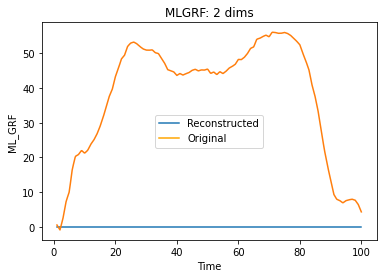

In [88]:
from matplotlib.lines import Line2D

MLGRF_recon = []
recon = []
comb_fd = []
orig = ML_GRF_stance_N_fd[10].data_matrix[0,:,:]
# for i in range(5):

i = 0

MLGRF_recon.append(skfda.FDataGrid(data_matrix=recon_VAE[i,:,:],grid_points=grid_points_100))
recon.append(MLGRF_recon[i][10].data_matrix[0,:,:])
new = np.zeros((5,2,100,1))
new[i,0,:,:] = recon[i]
new[i,1,:,:] = orig
comb_temp = skfda.FDataGrid(data_matrix=new[i,:,:,:],grid_points=grid_points_100)
comb_fd.append(comb_temp)
    
    
    
titles = ['MLGRF: 2 dims','MLGRF: 4 dims','MLGRF: 6 dims','MLGRF: 8 dims','MLGRF: 10 dims']
legend_elements = [Line2D([0], [0], label='Reconstructed'), 
                   Line2D([0], [0], color='orange', label='Original')]
file_names = ['Plots/AE_ML_GRF_2comp.png', 'Plots/AE_ML_GRF_4comp.png', 'Plots/AE_ML_GRF_6comp.png', 
             'Plots/AE_ML_GRF_8comp.png', 'Plots/AE_ML_GRF_10comp.png']
# for i in range(5):
fig = comb_fd[i].plot()
fig.show()
plt.title(titles[i])
plt.xlabel("Time")
plt.ylabel("ML_GRF")
plt.legend(handles = legend_elements)

fig.savefig(file_names[i], dpi=300)

In [ ]:
mse = np.zeros(5)
tss = np.zeros(5)
r2 = np.zeros(5)
for i in range(5):
    mse[i] = np.mean((recon_AE[i,10,:] - AP_GRF_stance_N_matrix[10,:])**2)
    tss[i] = np.mean((AP_GRF_stance_N_matrix[10,:] - AP_GRF_stance_N_mean_array[0,:])**2)
    r2[i] = 1-mse[i]/tss[i]